[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cyneuro/Basics-of-Neurons-and-Networks/blob/main/S6_STM_WTA/S6_STM_WTA.ipynb)

# S6 Two Neural Networks
## - (i) Short-term memory  (ii) Winner-take-all
##### Developed in the Neural Engineering Laboratory at the University of Missouri(Mizzou)

## Install NEURON

In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())  # checks to see if we are in google colab
if RunningInCOLAB:                                     # installs packages if in colab 
    !pip install ipywidgets &> /dev/null
    !pip install neuron==8.0.0 &> /dev/null

### Download modfiles from github

In [2]:
import os
from os.path import normpath, sep, join

root = 'Basics-of-Neurons-and-Networks'
folder = 'S6_STM_WTA'
pathlist = normpath(os.getcwd()).split(sep)
if pathlist[-1] != folder:
  rootidx = pathlist.index(root) if root in pathlist else -1
  if rootidx>0:
    os.chdir(join(sep,*pathlist[:rootidx]))
  !git clone https://github.com/cyneuro/Basics-of-Neurons-and-Networks.git &> /dev/null
  os.chdir(join(root,folder))

/Users/gregglickert/Documents/GitHub/Computational-Neuroscience-Tutorials/S6_STM_WTA
AMPA_syn.mod      S6_STM_WTA.ipynb  leak_current.mod
GABA_syn.mod      kd_current.mod    na_current.mod


#### Before running the simulation, you need to compile the mod files only once for the first time.

In [3]:
import os
print(os.system('nrnivmodl')) # compile modfiles. Return 0 for success, 1 for failure.

/Users/gregglickert/opt/anaconda3/envs/bmtk/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/usr/bin/xcrun
/Users/gregglickert/Documents/GitHub/Computational-Neuroscience-Tutorials/S6_STM_WTA
Mod files: "./AMPA_syn.mod" "./GABA_syn.mod" "./kd_current.mod" "./leak_current.mod" "./na_current.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../AMPA_syn.mod
 -> NMODL ../kd_current.mod
 -> NMODL ../GABA_syn.mod
 -> NMODL ../leak_current.mod
 -> NMODL ../na_current.mod
 -> Compiling AMPA_syn.c
 -> Compiling GABA_syn.c
 -> Compiling kd_current.c


Translating kd_current.mod into /Users/gregglickert/Documents/GitHub/Computational-Neuroscience-Tutorials/S6_STM_WTA/x86_64/kd_current.c
Translating GABA_syn.mod into /Users/gregglickert/Documents/GitHub/Computational-Neuroscience-Tutorials/S6_STM_WTA/x86_64/GABA_syn.c
Translating AMPA_syn.mod into /Users/gregglickert/Documents/GitHub/Computational-Neuroscience-Tutorials/S6_STM_WTA/x86_64/AMPA_syn.c
Thread Safe
Thread Safe
Thread Safe
Translating na_current.mod into /Users/gregglickert/Documents/GitHub/Computational-Neuroscience-Tutorials/S6_STM_WTA/x86_64/na_current.c
Translating leak_current.mod into /Users/gregglickert/Documents/GitHub/Computational-Neuroscience-Tutorials/S6_STM_WTA/x86_64/leak_current.c
Thread Safe
Thread Safe
kd_current.c:43:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
GABA_syn.c:42:18:          ext

 -> Compiling leak_current.c
 -> Compiling na_current.c


1 warning generated.
2 warnings generated.
2 warnings generated.
leak_current.c:41:18: warning: a function declaration without a prototype is deprecated in all versions of C and is treated as a zero-parameter prototype in C2x, conflicting with a previous declaration [-Wdeprecated-non-prototype]
         extern double *getarg();
                        ^
/Users/gregglickert/opt/anaconda3/envs/bmtk/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
/Users/gregglickert/opt/anaconda3/envs/bmtk/lib/python3.8/site-packages/neuron/.data/include/oc_ansi.h:49:16: note: conflicting prototype is here
extern double* getarg(int);
               ^
/Users/gregglickert/opt/anaconda3/envs/bmtk/lib/python3.8/site-packages/neuron/.data/include/hocdec.h:15:17: note: expanded from macro 'getarg'
#define getarg  hoc_getarg
                ^
1 warning generated.
na_current.c:43:18: warning: a function declaration wi

 => LINKING shared library ./libnrnmech.dylib
 => LINKING executable ./special LDFLAGS are:    
Successfully created x86_64/special
0


ld: warning: ignoring duplicate libraries: '-lnrnmech'


### Run the codes below and answer the 6 questions at the end.

In [4]:
import matplotlib.pyplot as plt
from neuron import h
h.load_file('stdrun.hoc')

h.dt = 0.025 # time step (resolution) of the simulation in ms
h.tstop = 700 # how long to run the simulation in ms
h.v_init= -75 # initial membrane potential in mV

# Single cell model
class FastSpiking(object):
    def __init__(self,net,nccl=1):
        # Create cections
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        # Topology
        self.dend.connect(self.soma(1),0)
        # Geometry & biophysics
        if net=='STM':
            self.soma.L = 42.346621 # micrometers
            self.soma.diam = 5.3132928 # micrometers
            self.soma.Ra = 150 # ohm-cm
        else:  # WTA
            self.soma.L = 15 # micrometers
            self.soma.diam = 15 # micrometers
            self.soma.Ra = 150*22.5 # ohm-cm
        self.soma.nseg = self.dend.nseg = 1
        self.dend.L = 150 # micrometers
        self.dend.diam = 10 # micrometers
        self.dend.Ra = 150 # ohm-cm
        self.soma.cm = self.dend.cm = 1 # uF/cm2
        # insert channels
        self.soma.insert('leak'); self.soma.insert('na'); self.soma.insert('kdr')
        self.soma.el_leak = -70; self.soma.ena = 45; self.soma.ek = -80 # mV
        self.soma.glbar_leak = 0.00005; self.soma.gnabar_na = .035; self.soma.gkdrbar_kdr = .008 # S/cm2
        self.dend.insert('leak'); self.dend.insert('na'); self.dend.insert('kdr')
        self.dend.el_leak = -70; self.dend.ena = 45; self.dend.ek = -80 # mV
        self.dend.glbar_leak = 0.00005; self.dend.gnabar_na = .010; self.dend.gkdrbar_kdr = .003 # S/cm2
        # insert IClamp
        self.ccl = []
        for i in range(nccl): self.ccl.append(h.IClamp(self.soma(0.5)))
        
    def set_ccl(self,amp,dur=None,delay=None,n=0):
        self.ccl[n].amp = amp
        if dur is not None: self.ccl[n].dur = dur
        if delay is not None: self.ccl[n].delay = delay

# Cell list of STM and WTA
NCell = 5
STM_Cell = []
STM_Cell.append(FastSpiking('STM',nccl=2))
for i in range(1,NCell): STM_Cell.append(FastSpiking('WTA',nccl=0))
WTA_Cell = []
for i in range(NCell): WTA_Cell.append(FastSpiking('WTA'))

# Create synaptic connection
NCthreshold = 0
NCdelay = 2
NCweight = 1
STMsyn = []; STMnc = []
WTAsyn = []; WTAnc = []
for i in range(NCell):
    for j in range(NCell):
        if i!=j:
            STMsyn.append(h.AMPA(STM_Cell[j].dend(0.9)))
            STMnc.append(h.NetCon(STM_Cell[i].soma(0.5)._ref_v,STMsyn[-1],NCthreshold,NCdelay,NCweight,sec=STM_Cell[i].soma))
            WTAsyn.append(h.GABA(WTA_Cell[j].soma(0.1)))
            WTAnc.append(h.NetCon(WTA_Cell[i].dend(0.5)._ref_v,WTAsyn[-1],NCthreshold,NCdelay,NCweight,sec=WTA_Cell[i].dend))

# Define vectors for recording variables and record
t_vec = h.Vector()
t_vec.record(h._ref_t);
STM_v_vec = []
WTA_v_vec = []
for i in range(NCell):
    STM_v_vec.append(h.Vector()); WTA_v_vec.append(h.Vector())
    STM_v_vec[i].record(STM_Cell[i].soma(0.5)._ref_v)
    WTA_v_vec[i].record(WTA_Cell[i].soma(0.5)._ref_v)
STM_ccl_vec = [h.Vector(),h.Vector()]
for i in range(2): STM_ccl_vec[i].record(STM_Cell[0].ccl[i]._ref_i);
WTA_ccl_vec = [h.Vector()]
WTA_ccl_vec[0].record(WTA_Cell[0].ccl[0]._ref_i);

In [5]:
def set_syn_weight(synapses,weight):
    for syn in synapses:
        syn.initW = weight

# Initialize synaptic weights
STM_wgt = 2.1
WTA_wgt = 9
set_syn_weight(STMsyn,STM_wgt)
set_syn_weight(WTAsyn,WTA_wgt)

# Initialize current clamp
STM_amp1 = 0.5; STM_amp2 = -0.15
STM_Cell[0].set_ccl(STM_amp1,50,100,n=0)
STM_Cell[0].set_ccl(STM_amp2,50,500,n=1)

WTA_amp = [.2,0,0,0,0]
# WTA_amp = [.321,.22,.219,.221,.2195]
for (amp,cell) in zip(WTA_amp,WTA_Cell):
    cell.set_ccl(amp,500,100)

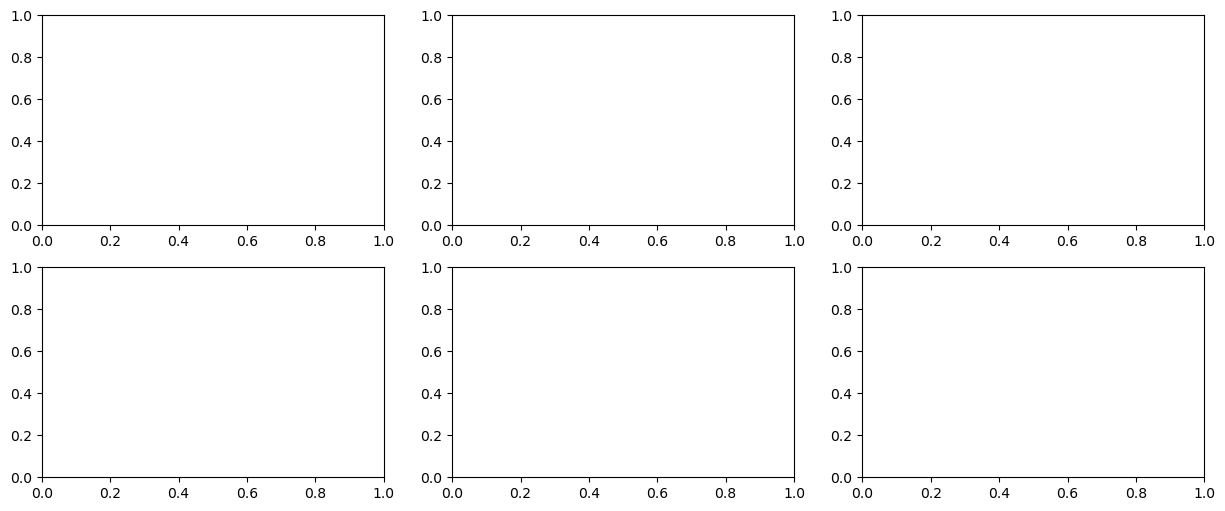

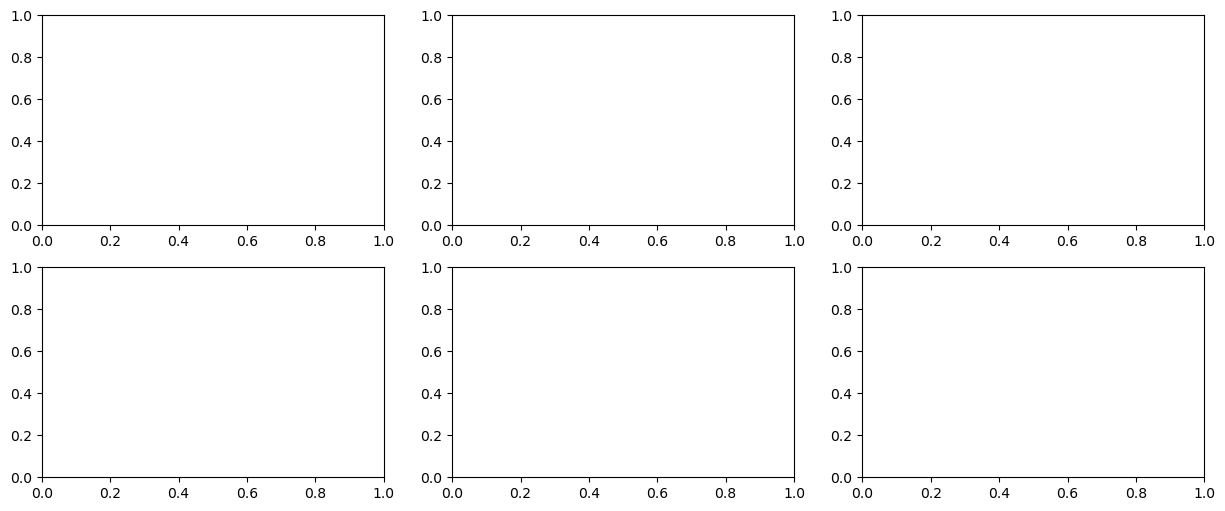

In [6]:
plt.ioff()
fig =[]; ax = []; axs = []
for i in range(2):
    fig.append(plt.figure(figsize=(15,6)))
    ax.append(fig[-1].add_subplot(2,3,4))
    axs.append([fig[-1].add_subplot(2,3,j+1 if j<3 else j+2) for j in range(NCell)])

def plot_variables(*arg):
    with out:
        clear_output(wait=True)
        display(fig[net.selected_index])

def run_show(*arg):
    set_syn_weight(STMsyn,w_wgt1.value)
    set_syn_weight(WTAsyn,w_wgt2.value)
    STM_Cell[0].set_ccl(w_Samp1.value,n=0)
    STM_Cell[0].set_ccl(w_Samp2.value,n=1)
    h.run()
    for i in range(2):
        ax[i].clear()
        for ccl in WTA_ccl_vec if i else STM_ccl_vec:
            ax[i].plot(t_vec,ccl)
        if i: ax[i].legend(['Current injection on all cells'],loc=1)
        else: ax[i].legend(['Current injection','on Cell 1'],loc=1)
        ax[i].set_xlim(0,h.tstop)
        ax[i].set_ylim(-0.2,0.8)
        for j in range(NCell):
            axs[i][j].clear()
            axs[i][j].plot(t_vec,WTA_v_vec[j] if i else STM_v_vec[j],'gray')
            axs[i][j].set_xlim(0,h.tstop)
            axs[i][j].set_ylim(-90,60)
            axs[i][j].legend(['Cell '+str(j+1)])
    plot_variables()

In [7]:
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display, clear_output
%matplotlib inline

w_reset = widgets.Button(description='Reset',icon='history',button_style='primary')
w_wgt1 = widgets.BoundedFloatText(value=STM_wgt,min=0,max=100,step=0.1)
w_wgt2 = widgets.BoundedFloatText(value=WTA_wgt,min=0,max=100,step=0.1)
w_Samp1 = widgets.FloatText(value=STM_amp1,step=0.05)
w_Samp2 = widgets.FloatText(value=STM_amp2,step=0.05)
w_Wamp = []
for i in range(NCell): w_Wamp.append(widgets.FloatText(value=WTA_amp[i],step=0.01,layout=Layout(width='80%')))

def reset_default(*args):
    w_wgt1.value = STM_wgt; w_wgt2.value = WTA_wgt
    w_Samp1.value = STM_amp1; w_Samp2.value = STM_amp2;
    for i in range(NCell): w_Wamp[i].value = WTA_amp[i]
    run_show()
w_reset.on_click(reset_default)

def update_Wamp(*args):
    for i in range(NCell): WTA_Cell[i].set_ccl(w_Wamp[i].value)
for w in w_Wamp: w.observe(update_Wamp,'value')

labels = [' ','Synaptic Weight','Current injection (nA): ','Cell 1 first pulse','Cell 1 second pulse']
for i in range(NCell): labels.append('Cell '+str(i+1))
Labels = [Label(L) for L in labels]
tab1 = VBox([ HBox([Labels[1],w_wgt1]), Labels[2], HBox([ VBox([Labels[3],w_Samp1]),VBox([Labels[4],w_Samp2]) ])])
tab2 = VBox([ HBox([Labels[1],w_wgt2]), Labels[2], HBox([VBox([Labels[i+5],w_Wamp[i]]) for i in range(5)]) ])

network = ['Short-Term Memory','Winner-Take-All']
net = widgets.Tab()
for i in range(2): net.set_title(i,network[i])
net.children = [tab1,tab2]
net.observe(plot_variables,'selected_index')

run_button = widgets.Button(description='Run & Show!',icon='play-circle',button_style='success')
run_button.on_click(run_show)

out = widgets.Output()
run_show()
display(VBox([w_reset,net,run_button,out]))

IndexError: list assignment index out of range

### Questions:
1. Explain the functioning of the ‘short term memory’ network. Provide all details.  
<br>
2. Explain the functioning of the Winner-Take-All network providing all details.  
<br>  
3. How would the behavior of the short-term-memory network, and the winner-take-all network change if spike frequency adaptation were to be included?  
<br>  
4. Explain biological applications that might use the short-term memory network, a winner-take-all network, and the half-center oscillator.  